In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 1000

In [2]:
data = pd.read_csv('sales-data.csv',parse_dates=['barr_date'])

data = data[(data.region_name=="Eurasia") & (data.business_area_name=="F00 - GCCT") & (data.barr_date<"2022-03-01")]
display(data.head())

data.rename(columns={"barr_date":"date","revenue": "sales"}, inplace=True)
data = data[['date','sales']]
data.set_index('date', inplace=True)
display(data)

,business_area_name,region_name,barr_date,revenue
25,F00 - GCCT,Eurasia,2022-02-01,309958.81
49,F00 - GCCT,Eurasia,2022-01-01,174459.20
71,F00 - GCCT,Eurasia,2021-12-01,208724.16
89,F00 - GCCT,Eurasia,2021-11-01,26147.63
130,F00 - GCCT,Eurasia,2021-10-01,27993.92


,sales
date,
2022-02-01,309958.81
2022-01-01,174459.20
2021-12-01,208724.16
2021-11-01,26147.63
2021-10-01,27993.92
2021-09-01,32277.44
2021-08-01,45464.66
2021-07-01,157558.37
2021-06-01,163370.90


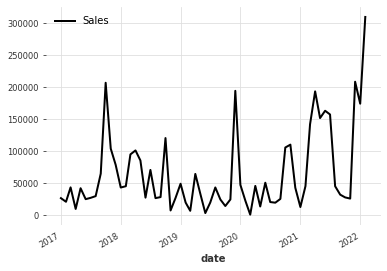

In [4]:
series_sales = TimeSeries.from_dataframe(data)

plt.ticklabel_format(style='plain')
series_sales.plot(label="Sales")
plt.legend()

In [5]:
data2 = pd.read_csv('commodity_index.csv',parse_dates=['ts_month'])

data2 = data2[(data2.ts_month>='2019-01-01')]
display(data2.head())

data2.rename(columns={"ts_month":"date","commodity_index": "values"}, inplace=True)
data3 = data2[['date','gold_index']]
data4 = data2[['date','silver_index']]
data5 = data2[['date','palladium_index']]
data6 = data2[['date','platinum_index']]

data2 = data2[['date','values']]
data2.set_index('date', inplace=True)
display(data2.head())

data3.set_index('date', inplace=True)
display(data3.head())

data4.set_index('date', inplace=True)
display(data4.head())

data5.set_index('date', inplace=True)
display(data5.head())

data6.set_index('date', inplace=True)
display(data6.head())

,ts_month,copper_index,ironore_index,lead_index,molybdenum_index,nickel_index,uranium_index,zinc_index,gold_index,platinum_index,palladium_index,silver_index,commodity_index
119,2019-01-01,0.62,0.41,0.77,0.64,0.45,0.43,1.07,0.95,0.45,1.68,0.55,0.83
120,2019-02-01,0.66,0.48,0.80,0.63,0.50,0.42,1.13,0.97,0.46,1.82,0.55,0.87
121,2019-03-01,0.67,0.48,0.79,0.67,0.51,0.40,1.18,0.96,0.47,1.93,0.54,0.88
122,2019-04-01,0.67,0.52,0.75,0.68,0.50,0.38,1.19,0.94,0.50,1.76,0.53,0.88
123,2019-05-01,0.63,0.56,0.70,0.67,0.47,0.37,1.10,0.94,0.46,1.68,0.51,0.85


,values
date,
2019-01-01,0.83
2019-02-01,0.87
2019-03-01,0.88
2019-04-01,0.88
2019-05-01,0.85


,gold_index
date,
2019-01-01,0.95
2019-02-01,0.97
2019-03-01,0.96
2019-04-01,0.94
2019-05-01,0.94


,silver_index
date,
2019-01-01,0.55
2019-02-01,0.55
2019-03-01,0.54
2019-04-01,0.53
2019-05-01,0.51


,palladium_index
date,
2019-01-01,1.68
2019-02-01,1.82
2019-03-01,1.93
2019-04-01,1.76
2019-05-01,1.68


,platinum_index
date,
2019-01-01,0.45
2019-02-01,0.46
2019-03-01,0.47
2019-04-01,0.50
2019-05-01,0.46


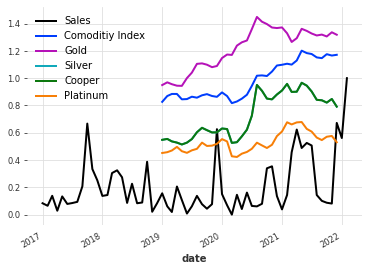

In [7]:
series_commodities = TimeSeries.from_dataframe(data2)
series_gold = TimeSeries.from_dataframe(data3)
series_silver = TimeSeries.from_dataframe(data4)
series_cooper = TimeSeries.from_dataframe(data5)
series_platinum = TimeSeries.from_dataframe(data6)

scaler_sales, scaler_commodities, scaler_gold, scaler_silver, scaler_cooper, scaler_platinum = Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
series_sales_scaled = scaler_sales.fit_transform(series_sales)
series_commodities_scaled = scaler_commodities.fit_transform(series_commodities)
series_gold_scaled = scaler_gold.fit_transform(series_gold)
series_silver_scaled = scaler_silver.fit_transform(series_silver)
series_cooper_scaled = scaler_cooper.fit_transform(series_cooper)
series_platinum_scaled = scaler_platinum.fit_transform(series_platinum)

plt.ticklabel_format(style='plain')
series_sales_scaled.plot(label="Sales")
series_commodities.plot(label="Comoditiy Index")
series_gold.plot(label="Gold")
series_silver.plot(label="Silver")
series_silver.plot(label="Cooper")
series_platinum.plot(label="Platinum")
plt.legend()

In [8]:
train_sales, val_sales = series_sales_scaled[:-12], series_sales_scaled[-12:]
train_commodities, val_commodities = series_commodities_scaled[:-12], series_commodities_scaled[-12:]
train_gold, val_gold = series_gold_scaled[:-12], series_gold_scaled[-12:]
train_silver, val_silver = series_silver_scaled[:-12], series_silver_scaled[-12:]
train_cooper, val_cooper = series_cooper_scaled[:-12], series_cooper_scaled[-12:]
train_platinum, val_platinum = series_platinum_scaled[:-12], series_platinum_scaled[-12:]
#train_miningGDP, val_miningGDP = series_miningGDP_scaled[:-12], series_miningGDP_scaled[-12:]

In [9]:
model_sales = NBEATSModel(input_chunk_length=12, output_chunk_length=12, n_epochs=50, random_state=0)
model_sales.fit([train_sales,train_commodities,train_gold,train_silver,train_cooper],verbose=True)

[2022-05-10 13:11:25,481] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 135 samples.
[2022-05-10 13:11:25,481] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 135 samples.
2022-05-10 13:11:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 135 samples.
[2022-05-10 13:11:25,542] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-10 13:11:25,542] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-10 13:11:25 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-05-10 13:11:25,543] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Training: 0it [00:00, ?it/s]

Predicting: 5it [00:00, ?it/s]

Predicting: 5it [00:00, ?it/s]

MAPE = 106.25%


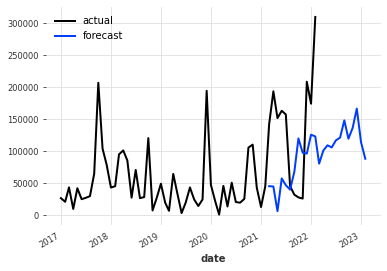

In [12]:
pred = model_sales.predict(n=24, series=train_sales)

original = scaler_sales.inverse_transform(series_sales_scaled)
predicted = scaler_sales.inverse_transform(pred)

plt.ticklabel_format(style='plain')
original.plot(label="actual")
predicted.plot(label="forecast")
plt.legend()

print("MAPE = {:.2f}%".format(mape(series_sales_scaled, pred)))

In [13]:
xxx = predicted['sales'].pd_dataframe()
xxx

component,sales
date,
2021-03-01,45510.00
2021-04-01,45016.53
2021-05-01,6469.71
2021-06-01,57651.81
2021-07-01,47044.43
2021-08-01,40157.69
2021-09-01,67924.67
2021-10-01,120137.35
2021-11-01,97817.53
